This tutorial has been modified from meps-cqr.ipynb from conformal-prediction (https://github.com/aangelopoulos/conformal-prediction). It is based on Romano et al. (2019) (https://proceedings.neurips.cc/paper/2019/hash/5103c3584b063c431bd1268e9b5e76fb-Abstract.html).

# Improved conditional coverage with *conformalized quantile regression* (CQR) using the Medical Expenditure Panel Survey (MEPS) data

In our demo, we looked at a regression example with a continuous output. To illustrate the distribution-free nature of the conformal prediction coverage guarantee, we used a base model and a nonconformity score that was obviously ill-suited to the data. In this tutorial, we will see that the same conformal prediction principle applied to more clever choices of the base model and the nonconformity score leads to a procedure that leads to prediction sets that tend to be more adaptive to different levels of noise while, of course, maintaining the same distribution-free coverage guarantee. This procedure is called *conformalized quantile regression* (CQR).

To explain the idea behind the procedure, suppose we have access to the conditional distribution of $Y \mid X = x$. Then, we could construct a $100 \times (1-\alpha)\%$ prediction interval using the *conditional quantile functions* as $[t_{\alpha/2}(x), t_{1-\alpha/2}(x)]$. Of course, in practice, we have to estimate these functions using the data. This can be done via any quantile regression methods, which are, you guessed it, methods for estimating $t_\gamma$, $\gamma \in [0,1]$. Let's suppose we already have some pre-trained $\hat{t}_{\alpha/2}, \hat{t}_{1-\alpha/2}(x)$ from running such methods.

Now, these methods typically yield consistent estimators under suitable conditions, but $\hat{t}_{\gamma} \neq t_\gamma$ and hence, the coverage of the interval $[\hat{t}_{\alpha/2}(x), \hat{t}_{1-\alpha/2}(x)]$ is off from the target of $1-\alpha$ in finite samples even when those conditions are met. So, what do we do? We "conformalize" this interval by constructing a new nonconformity score that measures how far each point deviates from the quantile regression output and adjust the interval accordingly.

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
!pip install -U --no-cache-dir gdown --pre

## Loading the MEPS data

We'll use the Medical Expenditure Panel Survey (MEPS) data, which contains information about healthcare expenditures. Our goal is to predict $Y$ medical expenses (\\$) based on $X$ various patient characteristics.

The data includes:
- X: Features related to patient demographics and health status
- Y: Medical expenses (our target variable)
- L: Lower quantile estimates from a pre-trained quantile regression model
- U: Upper quantile estimates from the same model

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
    
data = np.load('../data/meps/meps-gbr.npz')
X, Y, L, U = data['X'], data['y'], data['lower'], data['upper']

X shape: (7893, 139)
Y shape: (7893,)
L shape: (7893,)
U shape: (7893,)


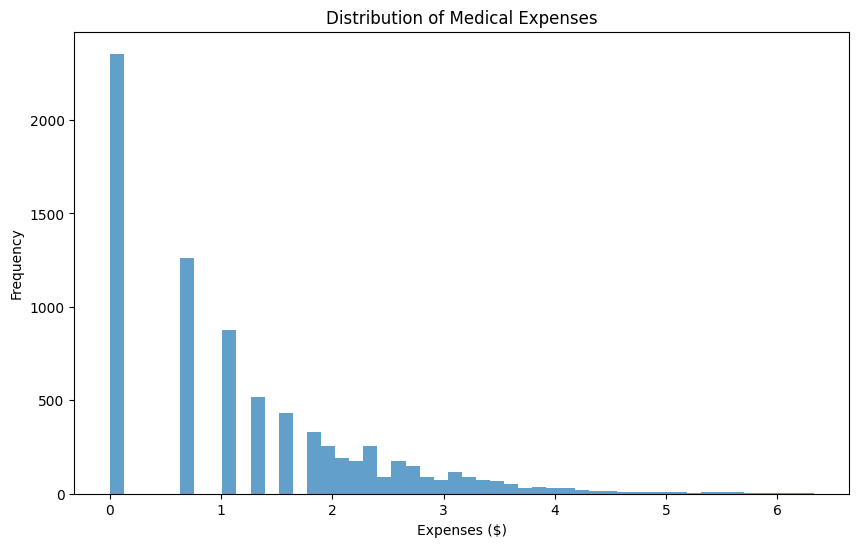

In [3]:
# Let's look at the data dimensions
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"L shape: {L.shape}")
print(f"U shape: {U.shape}")

# Plot the distribution of medical expenses
plt.figure(figsize=(10, 6))
plt.hist(Y, bins=50, alpha=0.7)
plt.title('Distribution of Medical Expenses')
plt.xlabel('Expenses ($)')
plt.ylabel('Frequency')
plt.show()

## Setting up the experiment

We need to:
1. Define the desired coverage level $1-α$
2. Split our data into calibration and test sets

In [4]:
# EXERCISE 1: Set the target miscoverage rate alpha and calibration set size m
alpha = 0.1 # 1-alpha is the desired coverage
m = 1000 # number of calibration points

In [5]:
# EXERCISE 2: Split the data into calibration and test sets
# Create a boolean mask for selecting calibration points
idx = np.array([1] * m + [0] * (Y.shape[0]-m)) > 0 # creates a 50000-vector of 1000 T's followed by F's
np.random.shuffle(idx) # shuffle to randomly select calibration points

# Use the mask to split the data
Y_cal, Y_te = Y[idx], Y[~idx]
L_cal, L_te = L[idx], L[~idx]
U_cal, U_te = U[idx], U[~idx]

## Conformalized quantile regression (CQR)

The CQR nonconformity score for an observation $(x,y)$ is:

$$s(x,y) = \max\left\{\hat{t}_{\alpha/2}(x)-y, y-\hat{t}_{1-\alpha/2}(x)\right\}$$

**Think.** What is this nonconformity score capturing?

In [6]:
# EXERCISE 3: Calculate nonconformity scores for the calibration set
S_cal = np.maximum(L_cal-Y_cal, Y_cal-U_cal)

# Sort the scores
S_cal = np.sort(S_cal)

# Calculate the conformity threshold (qhat)
# This is the (1-alpha) quantile of the nonconformity scores
qhat = S_cal[int(np.ceil((1-alpha)*(m+1)))-1]
# qhat = np.quantile(S_cal, np.ceil((1-alpha)*(m+1)/m, interpolation='higher')

## Constructing conformalized prediction intervals

Now, we can construct our conformalized prediction intervals for the test set. The interval is:

$$\hat C(x) = [\hat{t}_{\alpha/2}(x) - \hat{q}, \hat{t}_{1-\alpha/2}(x) + \hat{q}],$$

where $\hat{q}$ is our conformity threshold (qhat).

In [7]:
# EXERCISE 4: Construct conformalized prediction intervals
Chat = [L_te-qhat, U_te+qhat]

## Evaluating coverage

Let's check if our conformalized prediction intervals achieve the desired coverage. We'll also compare them with the original (non-conformalized) intervals $[\hat{t}_{\alpha/2}(x), \hat{t}_{1-\alpha/2}(x)]$.

In [8]:
# EXERCISE 5: Calculate and compare empirical coverage
# Coverage before conformalization
empirical_coverage0 = ((L_te <= Y_te) & (Y_te <= U_te)).mean()
print(f"The empirical coverage before conformalization is: {empirical_coverage0}")

# Coverage after conformalization
empirical_coverage = ((L_te-qhat <= Y_te) & (Y_te <= U_te+qhat)).mean()
print(f"The empirical coverage after conformalization is: {empirical_coverage}")

The empirical coverage before conformalization is: 0.7355287973306253
The empirical coverage after conformalization is: 0.9315247352386479


## Examining conditional coverage

One major advantage of conformalized prediction is improved conditional coverage across different subgroups. Let's check if our method achieves uniform coverage across different cancer diagnosis categories.

In [9]:
# The following lines appear to
#   1. Re-code different cancer diagnosis variables as 1-Yes and 0-No,
#   2. Aggregate the number of different cancer diagnoses.
# See https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H233&varName=CANCERDX
X_cancer = X[~idx, 40:45]
for col in range(X_cancer.shape[1]):
    one_val = X_cancer[:, col].max()
    X_cancer[:, col] = (X_cancer[:, col] == one_val).astype(int)
cancer_dx = X_cancer.dot(np.arange(5)+1).astype(int)

# Count observations in each cancer diagnosis category
counts = [(cancer_dx == dx).sum() for dx in np.arange(5)+1]
print("Number of observations per cancer diagnosis category:")
for i, count in enumerate(counts):
    print(f"Category {i+1}: {count}")
# Let's take a look at how many observations are in each level
#[(cancer_dx == dx).sum() for dx in np.arange(5)+1]

Number of observations per cancer diagnosis category:
Category 1: 2760
Category 2: 1924
Category 3: 1718
Category 4: 394
Category 5: 93


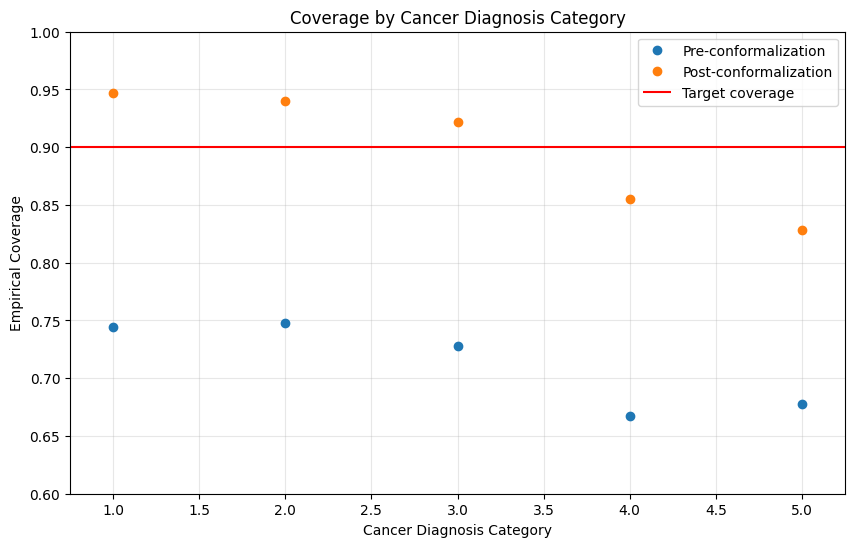

In [10]:
# EXERCISE 6: Calculate stratified coverage for each cancer diagnosis category
# Coverage before conformalization
stratified_coverage0 = [((L_te[cancer_dx == dx] <= Y_te[cancer_dx == dx])
                         & (Y_te[cancer_dx == dx] <= U_te[cancer_dx == dx])).mean() for dx in np.arange(5)+1]

# Coverage after conformalization
stratified_coverage = [((L_te[cancer_dx == dx]-qhat <= Y_te[cancer_dx == dx])
                        & (Y_te[cancer_dx == dx] <= U_te[cancer_dx == dx]+qhat)).mean() for dx in np.arange(5)+1]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(5)+1, stratified_coverage0, "o", label="Pre-conformalization")
plt.plot(np.arange(5)+1, stratified_coverage, "o", label="Post-conformalization")
plt.hlines(1-alpha, 0.5, 5.5, 'r', label="Target coverage")
plt.xlim(0.75, 5.25)
plt.ylim(0.6, 1.0)
plt.xlabel("Cancer Diagnosis Category")
plt.ylabel("Empirical Coverage")
plt.title("Coverage by Cancer Diagnosis Category")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Key takeaways

1. **The Coverage Problem**: Traditional quantile regression methods produce intervals that often don't achieve their target coverage in finite samples.

2. **Conformal Prediction Solution**: By applying conformal prediction techniques to quantile regression outputs, we can guarantee the desired coverage level (1-α) without making distributional assumptions.

3. **The CQR Procedure**:
   - Start with estimated conditional quantiles from any quantile regression method
   - Calculate nonconformity scores on a calibration set
   - Adjust the original interval based on these scores

4. **Empirical Results**:
   - Pre-conformalization intervals achieved ~73% coverage when targeting 90%
   - Post-conformalization intervals achieved ~93% coverage, meeting our target
   - Coverage was more uniform across different subgroups after conformalization

5. **Advantages**:
   - Distribution-free coverage guarantees
   - Can be applied on top of any existing quantile regression method
   - Improves conditional coverage across different subpopulations

6. **Limitations**:
   - Requires a separate calibration set
   - May produce wider intervals than uncalibrated methods

## Discussion questions

1. How does the conformalization process improve coverage compared to the original quantile regression intervals?

2. How would you expect the width of the prediction intervals to change after conformalization? Why?

3. What might explain any differences in coverage across the different cancer diagnosis categories?

4. How might the choice of the base quantile regression model affect the final conformalized intervals?

5. How would the choice of α affect our results? What tradeoffs are involved in selecting different values?

6. How should we decide the size of the calibration set? What happens if it's too small or too large?

7. How does CQR compare to other uncertainty quantification methods like bootstrap or Bayesian approaches?

8. In what real-world scenarios would guaranteed coverage be particularly important when predicting medical expenses?

9. How might conformal prediction help ensure fair treatment across different demographic groups?

10. How would you explain the concept of conformalized prediction intervals to non-technical stakeholders?